In [1]:
import os 

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import datasets 
import scipy

from statistics import NormalDist
from visualizations import *
from synthethic_data import *
from bootstrap_data_valuation import *

In [2]:
pd.set_option("display.max_rows",None)
np.set_printoptions(threshold=np.inf)

### Help funct

In [3]:
def prepare_df(df, data_noisy):
    df["noise"] = 0 
    df["class"] = 0

    # Workaround the hue paramter in sns.scatterplot()
    df["class_with_noise"] = 0

    for i in noise_idx["index"]:
        df.at[i,"noise"] = 1

    for index, row in data_noisy.iterrows():
        df.at[index,"class"] = row["class"]

    for index, row in df.iterrows():
        if (row["noise"] == 1):
            df.at[index,"class_with_noise"] = 2
        else:
            df.at[index,"class_with_noise"] = row["class"]

    df = df.merge(data_noisy.drop("class",axis=1),how="right",on="index")
    return df

## New Bootstrap method testing 

In [4]:
class bootstrap_data_valuation():
    
    folds = {}
    points_vector = {}
    subsets = {}
    subsets_performance = {}
    point_valuation = {}
    final_point_valuation = {}

    def __init__(self, data, model, target, n_bootstraps=100, n_folds=10):
        data["index"] = data.index
        self.data = data
        self.model = model
        self.target = target
        self.kf = KFold(n_splits=n_folds,shuffle=True)
        self.n_bootstrap_subsets = n_bootstraps
        
        self.df = pd.DataFrame(np.nan,
                               index=range(max(data.index)+1),
                               columns=range(self.kf.get_n_splits()))

    def create_subset(self, data):
        bootstrap_data = data.sample(len(data), replace=True)
        out_of_bag_data = data.drop(bootstrap_data.index)
        return bootstrap_data, out_of_bag_data
    
    def update_vector(self, bootstrap_subset, subset_n, fold):
        points = bootstrap_subset["index"]
        for point in points:
            self.points_vector[fold][point][subset_n] = 1

    def calculate_performance(self, model, train_data, test_data):
        Y_train = train_data[self.target]
        X_train = train_data.drop([self.target],axis=1)

        if ("index" in X_train.columns):
            X_train = X_train.drop("index",axis=1)

        X_test = test_data.drop([self.target],axis=1)
        Y_test = test_data[self.target]

        if ("index" in X_test.columns):
            X_test = X_test.drop("index",axis=1)


        model = model.fit(X_train,Y_train) 
        Y_pred = model.predict(X_test)
        acc_test = accuracy_score(Y_test, Y_pred)

        return acc_test
    def check_for_point(self,point_idx,bootstrap,k=1):
#         print("Len: ",len(bootstrap[bootstrap["index"]==point_idx]))
#         print("inside k: ",k)
#         print("Return value: ",(len(bootstrap[bootstrap["index"]==point_idx]) == k))
        return (len(bootstrap[bootstrap["index"]==point_idx]) == k)
        
    def perform_kfold_modified(self,k=1):
        fold=0
        self.point_valuation = {}
        for train, test in self.kf.split(self.data):
#             print(fold)
            self.point_valuation[fold] = {}
            self.subsets[fold] = {}
            subset_performance = []
            self.folds[fold] = {"train":self.data.iloc[train],
                                "test":self.data.iloc[test]}
            
            data = self.data.loc[self.folds[fold]["train"].index.tolist()]
            for point_idx in data["index"]:
#                 print("\nNew Point")
                self.point_valuation[fold][point_idx] = {"inside":0,
                                                         "outside":0,
                                                        "change":0}
                ret = 0
                # Get the inside accuracy 
                bootstrap_data, oob_data = self.create_subset(data)
                
                while (not self.check_for_point(point_idx, bootstrap_data,k=k)):
                    ret+=1
#                     print("while")
#                     print("outside k: ",k)
                    bootstrap_data, oob_data = self.create_subset(data)
                    
                acc = self.calculate_performance(self.model, bootstrap_data, oob_data)
                self.point_valuation[fold][point_idx]["inside"] = acc
                
                # Get the outside accuracy 
                bootstrap_data, oob_data = self.create_subset(data)
                
                while(self.check_for_point(point_idx,bootstrap_data)):
                    bootstrap_data, oob_data = self.create_subset(data)
                
#                 print(f"Fold: {fold}, Retries:{ret}")    
                acc = self.calculate_performance(self.model, bootstrap_data, oob_data)
                self.point_valuation[fold][point_idx]["outside"] = acc
                self.point_valuation[fold][point_idx]["change"] = self.point_valuation[fold][point_idx]["inside"] - self.point_valuation[fold][point_idx]["outside"]
                self.df.at[point_idx,fold] = self.point_valuation[fold][point_idx]["change"]
            
            fold+=1
        self.df["mean"] = self.df.mean(numeric_only=True, axis=1)
        self.df["index"] = self.df.index
            
            
        
    def perform_kfold(self):
        fold=0
        self.point_valuation = {}
        for train, test in self.kf.split(self.data):
            print(fold)
            self.point_valuation[fold] = {}
            self.subsets[fold] = {}
            subset_performance = []
            self.folds[fold] = {"train":self.data.iloc[train],
                                "test":self.data.iloc[test]}

            for point_idx in self.data.iloc[train]["index"]:
                self.point_valuation[fold][point_idx] = {"inside":[],
                                                         "outside":[]}
                
            data = self.data.loc[self.folds[fold]["train"].index.tolist()]
            
            for subset in range(self.n_bootstrap_subsets):
                bootstrap_data, oob_data = self.create_subset(data)
                self.subsets[fold][subset] = {"bootstrap": bootstrap_data,
                                              "out-of-bag": oob_data}
                acc = self.calculate_performance(self.model, bootstrap_data, oob_data)

                subset_performance.append(acc)
                self.performance(fold, bootstrap_data, acc)
                
            self.subsets_performance[fold] = subset_performance
            fold+=1
                
    def performance(self, fold, bootstrap_data, acc):
        for point in self.folds[fold]["train"].index:
            if (point in bootstrap_data.index):
                self.point_valuation[fold][point]["inside"].append(acc)
            else:
                self.point_valuation[fold][point]["outside"].append(acc)
                
            score_inside = self.point_valuation[fold][point]["inside"]
            score_outside = self.point_valuation[fold][point]["outside"]
            
            try:
                inside = (sum(score_inside)/len(score_inside)) * 100
                outside = (sum(score_outside)/len(score_outside)) * 100
                quality =  inside - outside
                self.point_valuation[fold][point]["avg_change_in_acc"] = quality
                self.df.at[point,fold] = quality
            except:
                pass

    def get_quality(self):
        self.perform_kfold()
        for point in self.data.index:
            self.final_point_valuation[point] = []

        for fold in self.point_valuation.keys():
            for point in self.point_valuation[fold].keys():
                self.final_point_valuation[point].append(self.point_valuation[fold][point]["avg_change_in_acc"])
    
    def transform_df(self):        
        self.df["mean"] = self.df.mean(numeric_only=True, axis=1)
        self.df = self.df.sort_values(["mean"], ascending=False)
        self.df["index"] = self.df.index
        
        return self.df
        
    def run_test2(self, threshold=-2, criteria=True, noise_reduction=True):
        print("Threshold: ",threshold)
        noise_to_remove = []
        noise_df = pd.DataFrame()
        threshold = threshold
        for fold in self.folds.keys():
            print(f"\nFold: {fold}")
            df = self.df[~self.df[fold].isnull()]

            if noise_reduction:
                idx_to_drop = df[df[fold]<threshold]["index"]
                print(f"Number of noisy datapoints: {len(idx_to_drop)}")
            else:
                idx_to_drop = df[df[fold]>threshold]["index"]
                print(f"Number of noisy datapoints: {len(idx_to_drop)}")
                
            train_data_fold = self.folds[fold]["train"]
            train_data_reduced_fold = self.folds[fold]["train"].drop(idx_to_drop)
            test_data_fold = self.folds[fold]["test"]

            try:
                print(f"Training on whole data: {len(train_data_fold)}")

                baseline_acc = self.calculate_performance(self.model,
                                      train_data_fold,
                                      test_data_fold)

                print(f"Training on reduced data: {len(train_data_reduced_fold)}")

                reduction_acc = self.calculate_performance(self.model,
                                      train_data_reduced_fold,
                                      test_data_fold)
                
                change = round((reduction_acc - baseline_acc)*100,5)
                print(f"Baseline accuracy: {round(baseline_acc,5)}")
                print(f"Accuracy after reduction: {round(reduction_acc,5)}")
                print(f"Change: {change}%")
                
                if ((change > 0)&(criteria)):
                    print("Adding")
                    noise_to_remove += list(idx_to_drop)
                    print("Printing: ",noise_to_remove)
                if(not criteria):
                    print("Adding anyways")
                    noise_to_remove += list(idx_to_drop)
                    print("Printing: ",noise_to_remove)
                    

            except:
                print("No datapoints found")
        
        print("\nLength of the whole list: ", len(noise_to_remove))
        print("Length of the list without duplicates: ", len(set(noise_to_remove)))
        noise_df["index"] = list(set(noise_to_remove))
        return noise_df


In [5]:
n=100
noise=0
overlap=0.25
k=0

classifier_single = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         max_depth=1,
                                         random_state=0)
df_pure, df_noisy, df_red_noise, noise_idx = prepare_data(n, noise, overlap)


In [6]:
valuation = bootstrap_data_valuation(df_noisy, classifier_single, "class", n_bootstraps=100, n_folds=10)
valuation.get_quality()
df = valuation.transform_df()
df = prepare_df(df, df_noisy)


0
1
2
3
4
5
6
7
8
9


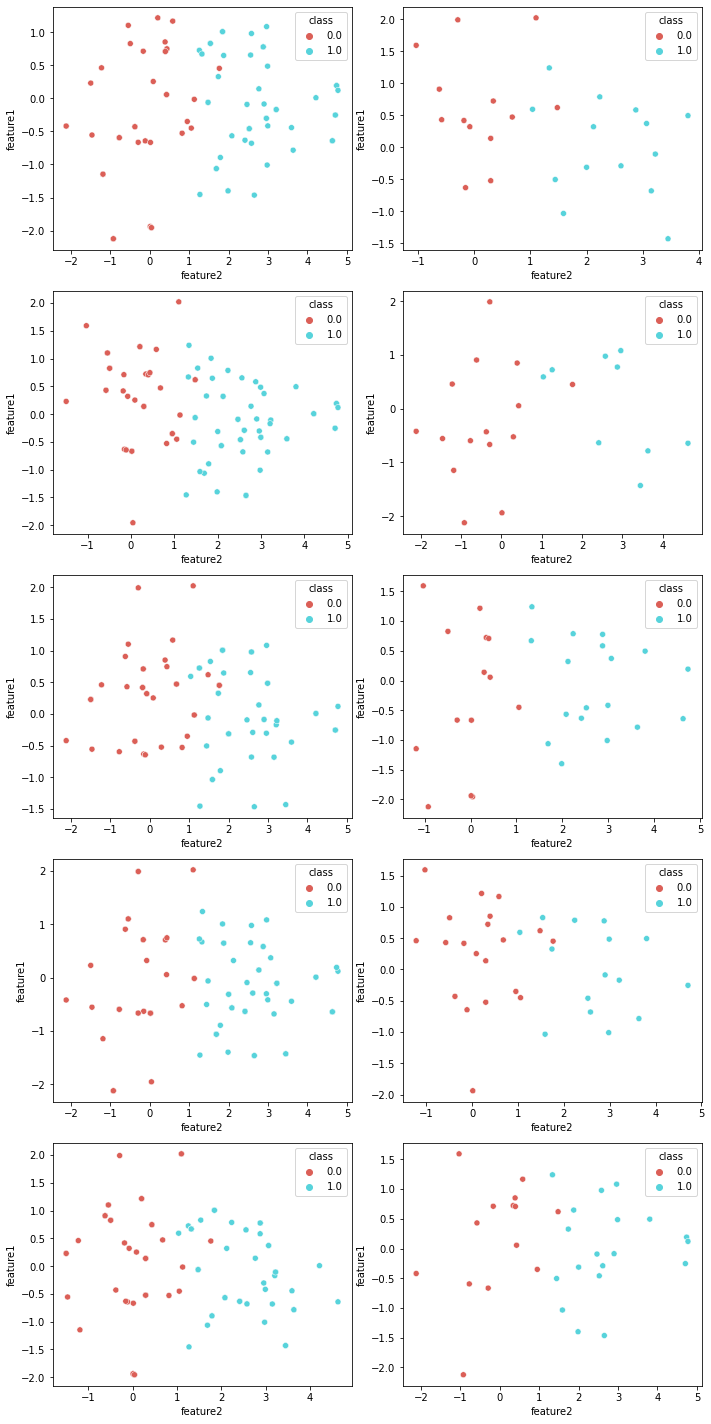

In [7]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import numpy as np

def viz_n_bootstraps(subsets,n):

    columns = 2
    rows = math.ceil(n/2)
    fig, axs = plt.subplots(nrows=rows,ncols=columns,figsize=(10, 20))
    fig.tight_layout(pad=2)
    
    keys = np.random.choice(list(subsets.keys()), size=n, replace=False)

    color = sns.color_palette("hls", 2)
    index=0
    for ax in axs:
        try:
            sns.scatterplot(x="feature2",
                            y="feature1",
                            hue="class",
                            palette=color,
                            legend=True,
                            data=subsets[keys[index]]["bootstrap"],
                            ax=ax[0])
            
            sns.scatterplot(x="feature2",
                            y="feature1",
                            hue="class",
                            palette=color,
                            legend=True,
                            data=subsets[keys[index]]["out-of-bag"],
                            ax=ax[1])
            index+=1
        except:
            fig.delaxes(ax)
        

viz_n_bootstraps(valuation.subsets[0],10)

In [56]:
valuation.subsets[0][0].keys()

dict_keys(['bootstrap', 'out-of-bag'])

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,mean,index,noise,class,class_with_noise,feature1,feature2
0,-0.342830,-0.242141,0.592016,0.463768,0.264619,0.160108,-0.025302,-0.015851,0.781799,NaN,0.181799,0,0,1,1,0.410802,2.683649
1,0.435563,0.447330,-0.104461,-0.004340,NaN,0.448834,0.270352,-0.403916,0.186417,0.033151,0.145436,1,0,1,1,0.051968,2.359883
2,0.273134,-0.249924,0.296588,0.378166,0.319691,-0.154355,-0.381910,-0.034449,NaN,0.145958,0.065878,2,0,0,0,1.245668,-0.065850
3,-0.119446,0.049662,0.500132,-0.560483,-0.072841,-0.805916,NaN,0.362463,0.140138,0.255620,-0.027852,3,0,1,1,1.091550,1.916857
4,0.143110,0.402169,0.189978,-0.231160,-0.508353,NaN,0.384610,-0.050236,-0.181542,-0.029095,0.013276,4,0,1,1,-0.250560,2.582231
5,-0.064460,-0.038347,0.120254,-0.042667,-0.160987,NaN,-0.570090,0.046156,-0.673315,0.279152,-0.122700,5,0,1,1,1.036085,3.289735
6,NaN,0.124567,0.161937,-0.273690,-0.447892,0.117032,0.180599,0.068444,-0.501243,0.285795,-0.031606,6,0,0,0,0.147817,-1.748594
7,-0.040239,-0.708743,0.147137,-0.427086,0.548140,0.291727,-0.503042,NaN,-0.592560,0.118411,-0.129584,7,0,0,0,2.642766,-1.031577
8,-0.348881,-0.045445,-0.023149,0.311201,-0.207817,-0.391188,-0.048473,0.098001,-0.838319,NaN,-0.166008,8,0,0,0,0.106909,0.082762
9,0.070305,0.293239,0.644851,NaN,-0.065115,-0.318296,-0.202587,0.190492,-0.264462,0.013275,0.040189,9,0,0,0,0.040172,-0.169756


In [11]:
home_path = f'C:\\Users\\Michauu\\BTR code'
os.chdir(home_path)

In [5]:
sizes = [100,250,500]
noise=0
overlaps=[0,0.25,0.5,1]
n_bootstraps=100

classifier_single = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         max_depth=1,
                                         random_state=0)
classifier_default = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         random_state=0)

classifiers = [classifier_single, classifier_default]

home_path = f'C:\\Users\\Michauu\\BTR code\different_k_params'
path = f"different_k_params/"
os.makedirs(path)
os.chdir(path)

for n in sizes:
    for overlap in overlaps:
        
        print(f"Param: {n}_{overlap}")
        
        newpath = f"{n}/{overlap}/" 
        os.makedirs(newpath)
        os.chdir(newpath)

        df_pure, df_noisy, df_red_noise, noise_idx = prepare_data(n, noise, overlap)
        
        for k in range(0,4):
            print("\nK: ", k)
            for classifier in classifiers:
                print(classifier)
                valuation = bootstrap_data_valuation(df_noisy, classifier, "class", n_bootstraps=n_bootstraps, n_folds=10)
                valuation.perform_kfold_modified(k=k)
                df = prepare_df(valuation.df, df_noisy)
                heat_map(df,f"k={k}",parameter_dict={"n":n,"noise":noise,"overlap":overlap,"tree":classifier},sep=False)

        os.chdir(home_path)

FileExistsError: [WinError 183] Nie można utworzyć pliku, który już istnieje: 'different_k_params/'

# Synthethic data

### Model performance on different datasets
- pure data: no noise
- data with artificial noise: a fraction of points had their label flipped
- data with randomly removed points
- data with artificial noise removed 

In [5]:
# acc_pure = cross_val_score(classifier,
#                 data_pure[["feature1","feature2"]],
#                 data_pure["class"])

# print(f"Acc pure: {acc_pure}, average: {round(acc_pure.mean(),3)}")

# acc_noisy = cross_val_score(classifier,
#                 data_noisy[["feature1","feature2"]],
#                 data_noisy["class"])
# print(f"\nAcc artificial noise: {acc_noisy}, average: {round(acc_noisy.mean(),3)}")

# acc_random = cross_val_score(classifier,
#                 data_random[["feature1","feature2"]],
#                 data_random["class"])
# print(f"\nAcc random removal: {acc_random}, average: {round(acc_random.mean(),3)}")

# acc_red_noise = cross_val_score(classifier,
#                 data_red_noise[["feature1","feature2"]],
#                 data_red_noise["class"])
# print(f"\nAcc no artificial noise: {acc_red_noise}, average: {round(acc_red_noise.mean(),3)}")

Acc pure: [0.865 0.855 0.85  0.85  0.835], average: 0.851

Acc artificial noise: [0.74  0.74  0.745 0.705 0.755], average: 0.737

Acc random removal: [0.86470588 0.84705882 0.83529412 0.84117647 0.82941176], average: 0.844

Acc no artificial noise: [0.87647059 0.84117647 0.84117647 0.82941176 0.84117647], average: 0.846


### Parameter tests

In [ ]:
import os 
# 100,250,500,1000, 5000 done
# 10000 done for 0.01 and 0.05 noise 
n_samples = [100,250,500,1000, 2500,5000,10000]
noise_levels = [0,0.01,0.05,0.1,0.15,0.25,0.5]
overlaps = [0.0,0.25,0.5,1.0]
ks = [1,2,3]

classifier_single = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         max_depth=1,
                                         random_state=0)

classifier_default = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         random_state=0)

classifiers = [classifier_single, classifier_default]
home_path = 'C:\\Users\\Michauu\\BTR code'

for n in n_samples:
    for noise in noise_levels:
        for overlap in overlaps:
            for k in ks:
                for classifier in classifiers:
                    param_dict = {'n':n,
                                  'noise':noise,
                                  'overlap':overlap,
                                  'tree':classifier.max_depth}

                    path = f"tests_for_k/{n}_points/{noise}_noise/{overlap}_overlap/{k}_k/{classifier.max_depth}_classifier"
                    os.makedirs(path)
                    os.chdir(path)
                    print("\nn: ", n, 
                          ", noise: ", noise,
                          ", overlap: ", overlap, 
                          ", k: ", k, 
                          ", classifier: ", classifier)

                    df_pure, df_noisy, df_red_noise, noise_idx = prepare_data(n, noise, overlap)
                    
# 
                    valuation = bootstrap_data_valuation(df_noisy, classifier, "class", n_bootstraps=100, n_folds=10)
                    valuation.perform_kfold_modified(k=k)
                    df = prepare_df(valuation.df, df_noisy)
                    heat_map(df,f"k={k}",parameter_dict={"n":n,"noise":noise,"overlap":overlap,"tree":classifier},sep=False)
# 

#                     valuation = bootstrap_data_valuation(df_noisy, classifier, "class", n_bootstraps=100, n_folds=10)
#                     valuation.get_quality()
#                     df = valuation.transform_df()
#                     df = prepare_df(df, df_noisy)

                    print("Creating and saving figures...")
                    vis_overlap(df_pure, parameter_dict=param_dict)
                    folds = valuation.kf.get_n_splits()

                    vis_folds(df,folds,parameter_dict=param_dict)
                    vis_hist_included_folds(df,folds,parameter_dict=param_dict)
                    vis_hist_excluded_folds(df,folds,parameter_dict=param_dict)
                    vis_hist_separate_folds(df,folds,parameter_dict=param_dict)

#                     data = df
#                     heat_map(data,"Change in accuracy for each point (separated by class and with noise included)",
#                              parameter_dict=param_dict)

#                     data = df
#                     heat_map(data,"Change in accuracy for each point (with noise included)",
#                              sep=False, parameter_dict=param_dict)

#                     data = df[df["class_with_noise"]!=2]
#                     heat_map(data,"Change in accuracy for each point (separated by class and with noise excluded)",
#                              parameter_dict=param_dict)

#                     data = df[df["class_with_noise"]!=2]
#                     heat_map(data,"Change in accuracy for each point (separated by class and with noise excluded)",
#                              sep=False, parameter_dict=param_dict)

                    data = df
                    heat_map(data,
                             "Change in accuracy for each point (separated by class and with noise as a separate class)",
                             col="class_with_noise", parameter_dict=param_dict)

                    vis_hist_included(df,parameter_dict=param_dict)
                    vis_hist_excluded(df,parameter_dict=param_dict)
                    vis_hist_separate(df,parameter_dict=param_dict)

                    os.chdir(home_path)
print("Done!")


n:  100 , noise:  0 , overlap:  0.0 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.0 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.0 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.0 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.0 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.0 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0 , overlap:  0.25 , k:  1 , classif

Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.0 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.0 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.25 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.25 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.25 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.05 , overlap:  0.25 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n


n:  100 , noise:  0.15 , overlap:  0.25 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overlap:  0.25 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overlap:  0.25 , k:  2 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overlap:  0.25 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overlap:  0.25 , k:  3 , classifier:  DecisionTreeClassifier(criterion='entropy', random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overlap:  0.5 , k:  1 , classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Creating and saving figures...

n:  100 , noise:  0.15 , overla

In [44]:
points_idx_to_remove = valuation.run_test2(threshold=0.5,criteria=True,noise_reduction=False)

NameError: name 'valuation' is not defined

### Analysis

How much of the generated artificial noise was detected

In [11]:
overlap_list = get_overlap(noise_idx["index"], points_idx_to_remove["index"])

There were 250 noisy datapoints
289 points were identified as noise
111/289 were correctly identified as noise. That is 38.4%


Plotting the cleared dataset

<AxesSubplot:title={'center':'After removing poor quality data\nPoints removed: 289'}, xlabel='feature1', ylabel='feature2'>

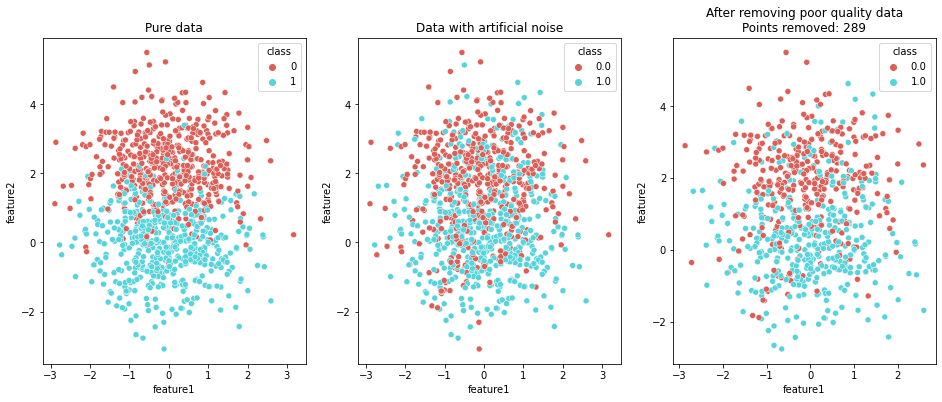

In [12]:
data_reduced = data_noisy[data_noisy["index"].isin(points_idx_to_remove["index"]) == False]

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6))

ax1.set_title("Pure data")
sns.scatterplot(x="feature1",
                y="feature2",
                hue="class",
                palette=sns.color_palette("hls",2),
                data=data_pure,
                legend="full",
                ax=ax1)

ax2.set_title("Data with artificial noise")
sns.scatterplot(x="feature1",
                y="feature2",
                hue="class",
                palette=sns.color_palette("hls",2),
                data=data_noisy,
                legend="full",
                ax=ax2)

ax3.set_title(f"After removing poor quality data\nPoints removed: {len(points_idx_to_remove)}")
sns.scatterplot(x="feature1",
                y="feature2",
                hue="class",
                palette=sns.color_palette("hls",2),
                data=data_reduced,
                legend="full",
                ax=ax3)

Checking the performance of the model after removing "bad quality" datapoints and after removing the all of the artificially generated noise

Average accuracy trained on noisy dataset: 0.669
Highest accuracy trained on correctly reduced noisy dataset: 0.848, fraction: 1.0
Highest accuracy for reduced noise: 0.757, fraction: 1.0


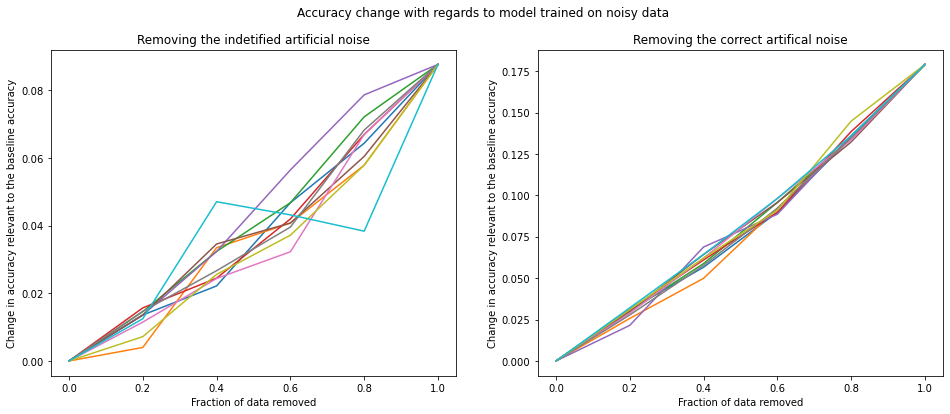

In [13]:
fractions = np.arange(0,1.2,0.2)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Accuracy change with regards to model trained on noisy data")
acc_scores=[]
max_correct_acc={"fraction":0,"acc":0}
max_red_acc={"fraction":0,"acc":0}

for _ in range(10):
    acc_change = []
    correct_acc_change = []
    
    for fraction in fractions:
        data_to_remove = points_idx_to_remove.sample(frac=fraction)
        data_reduced = data_noisy[data_noisy["index"].isin(data_to_remove["index"]) == False]
        
        correct_data_to_remove = noise_idx.sample(frac=fraction)
        correct_data_reduced = data_noisy[data_noisy["index"].isin(correct_data_to_remove["index"]) == False]

        Y = data_noisy["class"]
        X = data_noisy.drop(["class"],axis=1)
#         display(data_noisy)
        acc = cross_val_score(classifier, X, Y).mean()
        acc_scores.append(acc)
        
        Y_red = data_reduced["class"]
        X_red = data_reduced.drop(["class"],axis=1)
        
        acc_reduced = cross_val_score(classifier, X_red, Y_red).mean()
        if(acc_reduced > max_red_acc["acc"]):
            max_red_acc["acc"] = round(acc_reduced,3)
            max_red_acc["fraction"] = round(fraction,2)
            
        Y_correct_red = correct_data_reduced["class"]
        X_correct_red = correct_data_reduced.drop(["class"],axis=1)
        correct_acc_reduced = cross_val_score(classifier, X_correct_red, Y_correct_red).mean()
        if(correct_acc_reduced > max_correct_acc["acc"]):
            max_correct_acc["acc"] = round(correct_acc_reduced,3)
            max_correct_acc["fraction"] = round(fraction,2)
        
        change = round(acc_reduced - acc,4)
        correct_change = round(correct_acc_reduced - acc,4)
        
        acc_change.append(change)
        correct_acc_change.append(correct_change)
        
    ax1.set_title("Removing the indetified artificial noise")
    ax1.set_xlabel("Fraction of data removed")
    ax1.set_ylabel("Change in accuracy relevant to the baseline accuracy")
    ax1.plot(fractions, acc_change)
    
    ax2.set_title("Removing the correct artifical noise")
    ax2.set_xlabel("Fraction of data removed")
    ax2.set_ylabel("Change in accuracy relevant to the baseline accuracy")
    ax2.plot(fractions, correct_acc_change)
    
print(f"Average accuracy trained on noisy dataset: {round(np.array(acc_scores).mean(),3)}")
print(f"Highest accuracy trained on correctly reduced noisy dataset: {max_correct_acc['acc']}, fraction: {max_correct_acc['fraction']}")
print(f"Highest accuracy for reduced noise: {max_red_acc['acc']}, fraction: {max_red_acc['fraction']}")
